# Basic Version w/ Freeze Learning & Fine-tuning
For this approach, it will be used a pretrained DenseNet201, to which we will apply freeze learning and fine-tuning for our task.

In [1]:
import os

DATA_DIR = "../data/"
IMG_DIR = DATA_DIR + "/images/"
ANNOTATION_DIR = DATA_DIR + "/annotations/"
SPLITS_DIR = DATA_DIR + "/dl-split/"
OUT_DIR = "./out/basic_fine_tuned_balanced/"

os.makedirs(OUT_DIR, exist_ok=True)

SEED = 42

# Utility Function

In [2]:
import matplotlib.pyplot as plt
def plot_training_history(train_history, val_history, model_name, phase_name, out_dir):
    fig, (loss_ax, acc_ax) = plt.subplots(figsize=(12, 8), nrows=2)
    fig.suptitle(f"{model_name} - {phase_name} History")
    loss_ax.set_title("Cross Entropy Loss")
    loss_ax.plot(train_history["loss"], label="train")
    loss_ax.plot(val_history["loss"], label="val")
    loss_ax.legend(loc="best")

    acc_ax.set_title("Classification accuracy")
    acc_ax.plot(train_history["accuracy"], label="train")
    acc_ax.plot(val_history["accuracy"], label="val")
    loss_ax.legend(loc="best")

    plt.tight_layout()

    fig.savefig(f"{out_dir}/{model_name}_{phase_name}_history.png", dpi=150, bbox_inches='tight')

    return fig

## Load Dataset

In [3]:
# Fetching pre-defined splits
train_split = []
test_split = []

with open(SPLITS_DIR + "/train.txt") as train_split_f:
    train_split = [line.strip("\n") for line in train_split_f.readlines()]

with open(SPLITS_DIR + "/test.txt") as test_split_f:
    test_split = [line.strip("\n") for line in test_split_f.readlines()]

In [4]:
# Label mapping
label_encode_map = {
    "background": -100,
    "trafficlight": 0,
    "speedlimit": 1,
    "crosswalk": 2,
    "stop": 3,
}

label_decode_map = {
    -100: "background",
    0: "trafficlight",
    1: "speedlimit",
    2: "crosswalk",
    3: "stop",
}

# Split training dataset in a balanced manner

In [5]:
from utils.utils import parse_annotation

def get_annotations(split):
    annotations = {}
    for id in split:
        annotation = parse_annotation(f"{ANNOTATION_DIR}/{id}.xml", label_encode_map, return_biggest = True)
        annotation["labels"] = annotation["labels"][0]
        annotations[id] = annotation

    return annotations

annotations = get_annotations(train_split)

In [6]:
import pandas as pd
train_df = pd.DataFrame.from_dict(annotations, orient="index")
train_df

width  height  labels                           boxes     areas
road706  300.0   400.0       1  [[135.0, 159.0, 177.0, 201.0]]  [1764.0]
road538  300.0   400.0       1  [[115.0, 169.0, 149.0, 205.0]]  [1224.0]
road510  300.0   400.0       1   [[89.0, 201.0, 133.0, 245.0]]  [1936.0]
road504  300.0   400.0       1   [[92.0, 230.0, 139.0, 277.0]]  [2209.0]
road458  300.0   400.0       1   [[67.0, 116.0, 139.0, 189.0]]  [5256.0]
...        ...     ...     ...                             ...       ...
road247  300.0   400.0       1  [[139.0, 218.0, 156.0, 236.0]]   [306.0]
road253  300.0   400.0       1   [[128.0, 87.0, 187.0, 144.0]]  [3363.0]
road535  300.0   400.0       1  [[100.0, 254.0, 180.0, 334.0]]  [6400.0]
road284  300.0   400.0       1  [[111.0, 133.0, 165.0, 187.0]]  [2916.0]
road723  300.0   400.0       1  [[115.0, 185.0, 160.0, 230.0]]  [2025.0]

[613 rows x 5 columns]

Label Ratios
0    0.086460
1    0.730832
2    0.104405
3    0.078303
Name: labels, dtype: float64


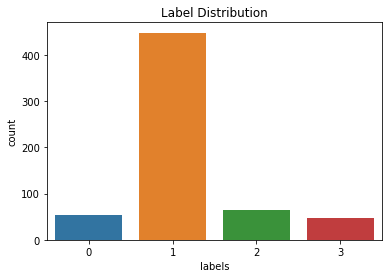

<Figure size 432x288 with 0 Axes>

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

print("Label Ratios")
label_ratios = (train_df["labels"].value_counts() / len(train_df["labels"])).sort_index()
print(label_ratios)

fig, ax = plt.subplots()
sns.countplot(data=train_df, x="labels", ax=ax, tick_label=["trafficlight", "speedlimit", "crosswalk", "stop"])
ax.set_title("Label Distribution")

plt.show()
plt.clf()

Train Label Ratios
1    0.732106
2    0.104294
0    0.085890
3    0.077710
Name: labels, dtype: float64
Validation Label Ratios
1    0.725806
2    0.104839
0    0.088710
3    0.080645
Name: labels, dtype: float64


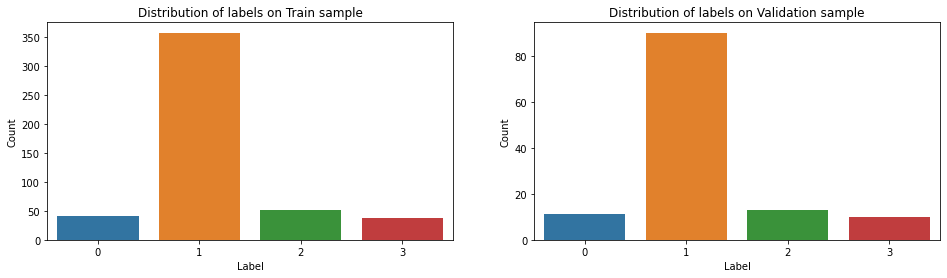

<Figure size 432x288 with 0 Axes>

In [8]:
# Maintain the ratios of labels across splits
train_sample = train_df.groupby("labels").sample(frac=0.8, random_state=SEED)
val_sample = train_df.loc[train_df.index.difference(train_sample.index)]

fig, (train_ax, val_ax) = plt.subplots(figsize=(16, 4), ncols=2)
for split, df, ax in zip(["Train", "Validation"], [train_sample, val_sample], [train_ax, val_ax]):
    sns.countplot(x=df["labels"], ax=ax)
    ax.set_title(f"Distribution of labels on {split} sample")
    ax.set_xlabel("Label")
    ax.set_ylabel("Count")
    
    print(f"{split} Label Ratios")
    print(pd.Series(df["labels"]).value_counts() / len(df["labels"]))
plt.show()
plt.clf()

In [9]:
from datasets.road_sign_dataset import RoadSignDataset

# Training dataset
training_data = RoadSignDataset(
    img_names=train_sample.index.tolist(),
    img_dir=IMG_DIR,
    annotation_dir=ANNOTATION_DIR,
    classes=label_encode_map,
    is_train=True,
    multilabel=False
)

# Validation dataset
validation_data = RoadSignDataset(
    img_names=val_sample.index.tolist(),
    img_dir=IMG_DIR,
    annotation_dir=ANNOTATION_DIR,
    classes=label_encode_map,
    is_train=True,
    multilabel=False
)

# Test dataset
testing_data = RoadSignDataset(
    img_names=test_split,
    img_dir=IMG_DIR,
    annotation_dir=ANNOTATION_DIR,
    classes=label_encode_map,
    is_train=False,
    multilabel=False,
)

# Create Dataloaders

In [10]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32 # Tested on 1050TI with 4GB (can load at least 64 as well, but doesn't make sense to use 64 with low amount of data)
NUM_WORKERS = 4

train_dataloader = DataLoader(
    dataset=training_data,
    #sampler=train_sampler,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
    drop_last=True,
    collate_fn=training_data.collate_fn
)

val_dataloader = DataLoader(
    dataset=validation_data,
    #sampler=val_sampler,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
    drop_last=True,
    collate_fn=training_data.collate_fn
)

test_dataloader = DataLoader(
    dataset=testing_data,
    batch_size=1,
    num_workers=NUM_WORKERS,
    shuffle=False,
    drop_last=False,
    collate_fn=testing_data.collate_fn
)

# Model Definition

In [11]:
from torchvision import models
from torch import nn
from torchinfo import summary

MODEL_NAME = "BASIC_FINE_TUNED"
N_CLASSES = 4

def get_model(n_classes):
    model = models.densenet201(pretrained=True)
    in_features = model.classifier.in_features
    model.classifier = nn.Linear(
        in_features=in_features,
        out_features=n_classes,
        bias=True
    )

    return model

model = get_model(n_classes=N_CLASSES)

summary(model)

Layer (type:depth-idx)                   Param #
DenseNet                                 --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       9,408
│    └─BatchNorm2d: 2-2                  128
│    └─ReLU: 2-3                         --
│    └─MaxPool2d: 2-4                    --
│    └─_DenseBlock: 2-5                  --
│    │    └─_DenseLayer: 3-1             45,440
│    │    └─_DenseLayer: 3-2             49,600
│    │    └─_DenseLayer: 3-3             53,760
│    │    └─_DenseLayer: 3-4             57,920
│    │    └─_DenseLayer: 3-5             62,080
│    │    └─_DenseLayer: 3-6             66,240
│    └─_Transition: 2-6                  --
│    │    └─BatchNorm2d: 3-7             512
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  32,768
│    │    └─AvgPool2d: 3-10              --
│    └─_DenseBlock: 2-7                  --
│    │    └─_DenseLayer: 3-11            53,760
│    │    └─_DenseLayer: 3-12     

# Define Optimizer, LR Scheduler, Loss function and Metric Scorer

In [12]:
from torch import optim
import torchmetrics

optimizer = optim.Adam(
    params=model.parameters(),
    lr=5e-3,
    betas=(0.9, 0.999),
    weight_decay=5e-4,
    amsgrad=True
)

lr_scheduler = optim.lr_scheduler.ExponentialLR(
    optimizer=optimizer,
    gamma=0.95
)

loss_fn = nn.CrossEntropyLoss(ignore_index=label_encode_map["background"])

metric_scorer = torchmetrics.Accuracy(
    threshold=0.5,
    num_classes=N_CLASSES,
    average="micro",
    ignore_index=label_encode_map["background"]
)

# Define Epoch Iteration

In [13]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

def epoch_iter(dataloader, model, loss_fn, device, is_train = True, optimizer=None, lr_scheduler=None):
    if is_train:
        assert optimizer is not None, "When training, please provide an optimizer."
      
    num_batches = len(dataloader)

    if is_train:
        model.train()
    else:
        model.eval()

    probs = []
    preds = []
    expected_labels = []
    imageIds = []

    total_loss = 0.0

    with torch.set_grad_enabled(is_train):
        for _batch, (X, y) in enumerate(tqdm(dataloader)):
            labels = y["labels"]
            ids = y["imageIds"]

            X, y = X.to(device), labels.to(device)

            pred = model(X)
            loss = loss_fn(pred, y)

            if is_train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            total_loss += loss.item()

            prob = F.softmax(pred, dim=1)
            final_pred = torch.argmax(prob, dim=1)

            probs.extend(prob.detach().cpu().numpy())
            preds.extend(final_pred.detach().cpu().numpy())
            expected_labels.extend(y.detach().cpu().numpy())
            imageIds.extend([f"road{imageId}" for imageId in ids.detach().cpu().numpy()])

        if is_train and lr_scheduler is not None:
            lr_scheduler.step()
    

    return (expected_labels, preds, probs, imageIds), total_loss / num_batches

# Train Model

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

Using device: cuda:0


In [15]:
NUM_EPOCHS = 30

model.to(device)
model.features.requires_grad_(False) # Freeze feature layer

train_history = {
    "loss": [],
    "accuracy": [],
}

val_history = {
    "loss": [],
    "accuracy": [],
}

best_val_loss = np.inf
best_val_accuracy = 0
best_epoch = -1

print(f"Starting {MODEL_NAME} training...")

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"Epoch[{epoch}/{NUM_EPOCHS}]")
    (train_target, train_preds, train_probs, _), train_loss = epoch_iter(
        dataloader=train_dataloader,
        model=model,
        loss_fn=loss_fn,
        device=device,
        is_train=True,
        optimizer=optimizer,
        lr_scheduler=lr_scheduler
    )

    train_accuracy = metric_scorer(torch.tensor(np.array(train_probs)), torch.tensor(np.array(train_target))).item()
    print(f"Training loss: {train_loss:.3f}\t Training micro accuracy: {train_accuracy:.3f}")

    (val_target, val_preds, val_probs, _), val_loss = epoch_iter(
        dataloader=val_dataloader,
        model=model,
        loss_fn=loss_fn,
        device=device,
        is_train=False,
    )

    val_accuracy = metric_scorer(torch.tensor(np.array(val_probs)), torch.tensor(np.array(val_target))).item()
    print(f"Validation loss: {val_loss:.3f}\t Validation micro accuracy: {val_accuracy:.3f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_accuracy = val_accuracy
        best_epoch = epoch
        save_dict = {"model": model.state_dict(), "optimizer": optimizer.state_dict(), "lr_scheduler": lr_scheduler.state_dict(), "epoch": epoch}
        torch.save(save_dict, f"{OUT_DIR}/{MODEL_NAME}_best_model.pth")

    # Save latest model
    save_dict = {"model": model.state_dict(), "optimizer": optimizer.state_dict(), "lr_scheduler": lr_scheduler.state_dict(), "epoch": epoch}
    torch.save(save_dict, f"{OUT_DIR}/{MODEL_NAME}_latest_model.pth")

    # Save loss and accuracy in history
    train_history["loss"].append(train_loss)
    train_history["accuracy"].append(train_accuracy)

    val_history["loss"].append(val_loss)
    val_history["accuracy"].append(val_accuracy)

    print("----------------------------------------------------------------")

print(
    f"\nFinished training..."
    f"\nBest epoch: {best_epoch}\t Validation loss on best epoch: {best_val_loss}\t Accuracy on best epoch: {best_val_accuracy}"
)

Starting BASIC_FINE_TUNED training...
Epoch[1/30]


100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


Training loss: 1.079	 Training micro accuracy: 0.717


100%|██████████| 3/3 [00:06<00:00,  2.19s/it]


Validation loss: 0.667	 Validation micro accuracy: 0.795
----------------------------------------------------------------
Epoch[2/30]


100%|██████████| 15/15 [00:09<00:00,  1.60it/s]


Training loss: 0.510	 Training micro accuracy: 0.826


100%|██████████| 3/3 [00:04<00:00,  1.47s/it]


Validation loss: 0.582	 Validation micro accuracy: 0.764
----------------------------------------------------------------
Epoch[3/30]


100%|██████████| 15/15 [00:09<00:00,  1.58it/s]


Training loss: 0.387	 Training micro accuracy: 0.874


100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Validation loss: 0.607	 Validation micro accuracy: 0.767
----------------------------------------------------------------
Epoch[4/30]


100%|██████████| 15/15 [00:09<00:00,  1.59it/s]


Training loss: 0.353	 Training micro accuracy: 0.884


100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Validation loss: 0.295	 Validation micro accuracy: 0.956
----------------------------------------------------------------
Epoch[5/30]


100%|██████████| 15/15 [00:09<00:00,  1.57it/s]


Training loss: 0.340	 Training micro accuracy: 0.900


100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Validation loss: 0.377	 Validation micro accuracy: 0.875
----------------------------------------------------------------
Epoch[6/30]


100%|██████████| 15/15 [00:09<00:00,  1.58it/s]


Training loss: 0.263	 Training micro accuracy: 0.921


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


Validation loss: 0.314	 Validation micro accuracy: 0.891
----------------------------------------------------------------
Epoch[7/30]


100%|██████████| 15/15 [00:09<00:00,  1.57it/s]


Training loss: 0.255	 Training micro accuracy: 0.922


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


Validation loss: 0.308	 Validation micro accuracy: 0.860
----------------------------------------------------------------
Epoch[8/30]


100%|██████████| 15/15 [00:10<00:00,  1.45it/s]


Training loss: 0.243	 Training micro accuracy: 0.918


100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


Validation loss: 0.340	 Validation micro accuracy: 0.899
----------------------------------------------------------------
Epoch[9/30]


100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Training loss: 0.206	 Training micro accuracy: 0.925


100%|██████████| 3/3 [00:06<00:00,  2.20s/it]


Validation loss: 0.352	 Validation micro accuracy: 0.919
----------------------------------------------------------------
Epoch[10/30]


100%|██████████| 15/15 [00:11<00:00,  1.32it/s]


Training loss: 0.204	 Training micro accuracy: 0.954


100%|██████████| 3/3 [00:05<00:00,  1.90s/it]


Validation loss: 0.316	 Validation micro accuracy: 0.889
----------------------------------------------------------------
Epoch[11/30]


100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Training loss: 0.176	 Training micro accuracy: 0.946


100%|██████████| 3/3 [00:05<00:00,  1.69s/it]


Validation loss: 0.305	 Validation micro accuracy: 0.888
----------------------------------------------------------------
Epoch[12/30]


100%|██████████| 15/15 [00:10<00:00,  1.45it/s]


Training loss: 0.163	 Training micro accuracy: 0.954


100%|██████████| 3/3 [00:05<00:00,  1.87s/it]


Validation loss: 0.236	 Validation micro accuracy: 0.935
----------------------------------------------------------------
Epoch[13/30]


100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


Training loss: 0.163	 Training micro accuracy: 0.949


100%|██████████| 3/3 [00:05<00:00,  1.92s/it]


Validation loss: 0.277	 Validation micro accuracy: 0.890
----------------------------------------------------------------
Epoch[14/30]


100%|██████████| 15/15 [00:11<00:00,  1.35it/s]


Training loss: 0.149	 Training micro accuracy: 0.963


100%|██████████| 3/3 [00:08<00:00,  2.76s/it]


Validation loss: 0.286	 Validation micro accuracy: 0.923
----------------------------------------------------------------
Epoch[15/30]


100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


Training loss: 0.154	 Training micro accuracy: 0.953


100%|██████████| 3/3 [00:06<00:00,  2.12s/it]


Validation loss: 0.493	 Validation micro accuracy: 0.841
----------------------------------------------------------------
Epoch[16/30]


100%|██████████| 15/15 [00:11<00:00,  1.30it/s]


Training loss: 0.169	 Training micro accuracy: 0.963


100%|██████████| 3/3 [00:05<00:00,  1.91s/it]


Validation loss: 0.191	 Validation micro accuracy: 0.935
----------------------------------------------------------------
Epoch[17/30]


100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


Training loss: 0.174	 Training micro accuracy: 0.949


100%|██████████| 3/3 [00:07<00:00,  2.39s/it]


Validation loss: 0.184	 Validation micro accuracy: 0.941
----------------------------------------------------------------
Epoch[18/30]


100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


Training loss: 0.135	 Training micro accuracy: 0.957


100%|██████████| 3/3 [00:05<00:00,  1.93s/it]


Validation loss: 0.275	 Validation micro accuracy: 0.889
----------------------------------------------------------------
Epoch[19/30]


100%|██████████| 15/15 [00:11<00:00,  1.31it/s]


Training loss: 0.132	 Training micro accuracy: 0.961


100%|██████████| 3/3 [00:06<00:00,  2.20s/it]


Validation loss: 0.343	 Validation micro accuracy: 0.898
----------------------------------------------------------------
Epoch[20/30]


100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


Training loss: 0.157	 Training micro accuracy: 0.949


100%|██████████| 3/3 [00:05<00:00,  1.76s/it]


Validation loss: 0.437	 Validation micro accuracy: 0.868
----------------------------------------------------------------
Epoch[21/30]


100%|██████████| 15/15 [00:14<00:00,  1.07it/s]


Training loss: 0.115	 Training micro accuracy: 0.971


100%|██████████| 3/3 [00:07<00:00,  2.44s/it]


Validation loss: 0.323	 Validation micro accuracy: 0.902
----------------------------------------------------------------
Epoch[22/30]


100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


Training loss: 0.169	 Training micro accuracy: 0.946


100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Validation loss: 0.219	 Validation micro accuracy: 0.920
----------------------------------------------------------------
Epoch[23/30]


100%|██████████| 15/15 [00:10<00:00,  1.45it/s]


Training loss: 0.154	 Training micro accuracy: 0.955


100%|██████████| 3/3 [00:05<00:00,  1.76s/it]


Validation loss: 0.306	 Validation micro accuracy: 0.892
----------------------------------------------------------------
Epoch[24/30]


100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Training loss: 0.157	 Training micro accuracy: 0.945


100%|██████████| 3/3 [00:05<00:00,  1.86s/it]


Validation loss: 0.263	 Validation micro accuracy: 0.910
----------------------------------------------------------------
Epoch[25/30]


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Training loss: 0.112	 Training micro accuracy: 0.964


100%|██████████| 3/3 [00:06<00:00,  2.20s/it]


Validation loss: 0.189	 Validation micro accuracy: 0.946
----------------------------------------------------------------
Epoch[26/30]


100%|██████████| 15/15 [00:11<00:00,  1.29it/s]


Training loss: 0.168	 Training micro accuracy: 0.955


100%|██████████| 3/3 [00:07<00:00,  2.63s/it]


Validation loss: 0.256	 Validation micro accuracy: 0.945
----------------------------------------------------------------
Epoch[27/30]


100%|██████████| 15/15 [00:10<00:00,  1.45it/s]


Training loss: 0.114	 Training micro accuracy: 0.977


100%|██████████| 3/3 [00:05<00:00,  1.79s/it]


Validation loss: 0.181	 Validation micro accuracy: 0.944
----------------------------------------------------------------
Epoch[28/30]


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


Training loss: 0.174	 Training micro accuracy: 0.940


100%|██████████| 3/3 [00:06<00:00,  2.08s/it]


Validation loss: 0.288	 Validation micro accuracy: 0.910
----------------------------------------------------------------
Epoch[29/30]


100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


Training loss: 0.141	 Training micro accuracy: 0.957


100%|██████████| 3/3 [00:06<00:00,  2.18s/it]


Validation loss: 0.298	 Validation micro accuracy: 0.908
----------------------------------------------------------------
Epoch[30/30]


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Training loss: 0.183	 Training micro accuracy: 0.946


100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Validation loss: 0.218	 Validation micro accuracy: 0.945
----------------------------------------------------------------

Finished training...
Best epoch: 27	 Validation loss on best epoch: 0.18091050535440445	 Accuracy on best epoch: 0.9438202381134033


C:\Users\telmo\AppData\Local\Temp/ipykernel_16048/3610660889.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


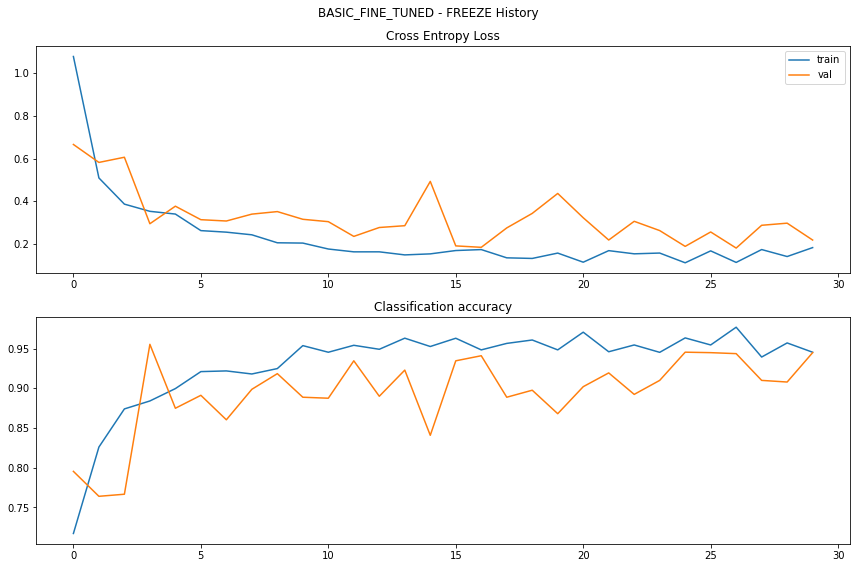

In [16]:
fig = plot_training_history(train_history=train_history, val_history=val_history, model_name=MODEL_NAME, phase_name="FREEZE", out_dir=OUT_DIR)
fig.show()

Clear GPU memory for guarantees

In [17]:
import gc
model = None

gc.collect()
torch.cuda.empty_cache()
torch.cuda.mem_get_info(device)

(2877462939, 4294836224)

In [18]:
!nvidia-smi

Fri Jun 10 14:03:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.95       Driver Version: 512.95       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   64C    P8    N/A /  N/A |    674MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Fine-tune the model

Load best model from first training session

In [19]:
BATCH_SIZE = 8 # Have to reduce batch size otherwise GPU memory dies (tested on 1050TI with 4GB)

train_dataloader = DataLoader(
    dataset=training_data,
    #sampler=train_sampler,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
    drop_last=True,
    collate_fn=training_data.collate_fn
)

val_dataloader = DataLoader(
    dataset=validation_data,
    #sampler=val_sampler,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True, # Must be False because we're using a random sampler already
    drop_last=True,
    collate_fn=training_data.collate_fn
)

In [20]:
best_checkpoint = torch.load(f"{OUT_DIR}/{MODEL_NAME}_best_model.pth")
model = get_model(n_classes=N_CLASSES)
model.load_state_dict(best_checkpoint["model"])
best_checkpoint = None

model.to(device)


print("Loaded best model...")

Loaded best model...


In [21]:
ft_optimizer = optim.Adam(
    params=model.parameters(),
    lr=1e-5,
    betas=(0.9, 0.999),
    weight_decay=5e-4,
    amsgrad=True
)

ft_lr_scheduler = optim.lr_scheduler.ExponentialLR(
    optimizer=ft_optimizer,
    gamma=0.9
)

In [22]:
FT_NUM_EPOCHS = 15
model.features.requires_grad_(True) # Unfreeze feature layer for fine-tuning

ft_train_history = {
    "loss": [],
    "accuracy": [],
}

ft_val_history = {
    "loss": [],
    "accuracy": [],
}

ft_best_val_loss = best_val_loss
ft_best_val_accuracy = best_val_accuracy
ft_best_epoch = -1

print(f"Starting {MODEL_NAME} fine-tuning...")

for epoch in range(1, FT_NUM_EPOCHS + 1):
    print(f"Epoch[{epoch}/{FT_NUM_EPOCHS}]")
    (train_target, train_preds, train_probs, _), train_loss = epoch_iter(
        dataloader=train_dataloader,
        model=model,
        loss_fn=loss_fn,
        device=device,
        is_train=True,
        optimizer=ft_optimizer,
        lr_scheduler=ft_lr_scheduler
    )

    train_accuracy = metric_scorer(torch.tensor(np.array(train_probs)), torch.tensor(np.array(train_target))).item()
    print(f"Training loss: {train_loss:.3f}\t Training micro accuracy: {train_accuracy:.3f}")

    (val_target, val_preds, val_probs, _), val_loss = epoch_iter(
        dataloader=val_dataloader,
        model=model,
        loss_fn=loss_fn,
        device=device,
        is_train=False,
    )

    val_accuracy = metric_scorer(torch.tensor(np.array(val_probs)), torch.tensor(np.array(val_target))).item()
    print(f"Validation loss: {val_loss:.3f}\t Validation micro accuracy: {val_accuracy:.3f}")

    # Save best model
    if val_loss < ft_best_val_loss:
        ft_best_val_loss = val_loss
        ft_best_val_accuracy = val_accuracy
        ft_best_epoch = epoch
        save_dict = {"model": model.state_dict(), "optimizer": ft_optimizer.state_dict(), "lr_scheduler": ft_lr_scheduler.state_dict(), "epoch": epoch}
        torch.save(save_dict, f"{OUT_DIR}/{MODEL_NAME}_ft_best_model.pth")

    # Save latest model
    save_dict = {"model": model.state_dict(), "optimizer": ft_optimizer.state_dict(), "lr_scheduler": ft_lr_scheduler.state_dict(), "epoch": epoch}
    torch.save(save_dict, f"{OUT_DIR}/{MODEL_NAME}_ft_latest_model.pth")

    # Save loss and accuracy in history
    ft_train_history["loss"].append(train_loss)
    ft_train_history["accuracy"].append(train_accuracy)

    ft_val_history["loss"].append(val_loss)
    ft_val_history["accuracy"].append(val_accuracy)

    print("----------------------------------------------------------------")

print(
    f"\nFinished fine-tuning..."
    f"\nBest epoch: {ft_best_epoch}\t Validation loss on best epoch: {ft_best_val_loss}\t Accuracy on best epoch: {ft_best_val_accuracy}"
)

Starting BASIC_FINE_TUNED fine-tuning...
Epoch[1/15]


100%|██████████| 61/61 [00:27<00:00,  2.20it/s]


Training loss: 0.183	 Training micro accuracy: 0.930


100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


Validation loss: 0.225	 Validation micro accuracy: 0.920
----------------------------------------------------------------
Epoch[2/15]


100%|██████████| 61/61 [00:29<00:00,  2.04it/s]


Training loss: 0.176	 Training micro accuracy: 0.956


100%|██████████| 15/15 [00:15<00:00,  1.01s/it]


Validation loss: 0.232	 Validation micro accuracy: 0.933
----------------------------------------------------------------
Epoch[3/15]


100%|██████████| 61/61 [00:31<00:00,  1.92it/s]


Training loss: 0.180	 Training micro accuracy: 0.946


100%|██████████| 15/15 [00:06<00:00,  2.16it/s]


Validation loss: 0.297	 Validation micro accuracy: 0.912
----------------------------------------------------------------
Epoch[4/15]


100%|██████████| 61/61 [00:32<00:00,  1.87it/s]


Training loss: 0.170	 Training micro accuracy: 0.953


100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


Validation loss: 0.268	 Validation micro accuracy: 0.920
----------------------------------------------------------------
Epoch[5/15]


100%|██████████| 61/61 [00:33<00:00,  1.82it/s]


Training loss: 0.191	 Training micro accuracy: 0.945


100%|██████████| 15/15 [00:06<00:00,  2.44it/s]


Validation loss: 0.219	 Validation micro accuracy: 0.955
----------------------------------------------------------------
Epoch[6/15]


100%|██████████| 61/61 [00:30<00:00,  2.01it/s]


Training loss: 0.125	 Training micro accuracy: 0.965


100%|██████████| 15/15 [00:12<00:00,  1.15it/s]


Validation loss: 0.176	 Validation micro accuracy: 0.946
----------------------------------------------------------------
Epoch[7/15]


100%|██████████| 61/61 [00:33<00:00,  1.84it/s]


Training loss: 0.103	 Training micro accuracy: 0.973


100%|██████████| 15/15 [00:10<00:00,  1.46it/s]


Validation loss: 0.283	 Validation micro accuracy: 0.929
----------------------------------------------------------------
Epoch[8/15]


100%|██████████| 61/61 [00:27<00:00,  2.18it/s]


Training loss: 0.108	 Training micro accuracy: 0.972


100%|██████████| 15/15 [00:10<00:00,  1.50it/s]


Validation loss: 0.199	 Validation micro accuracy: 0.907
----------------------------------------------------------------
Epoch[9/15]


100%|██████████| 61/61 [00:33<00:00,  1.82it/s]


Training loss: 0.110	 Training micro accuracy: 0.976


100%|██████████| 15/15 [00:09<00:00,  1.67it/s]


Validation loss: 0.211	 Validation micro accuracy: 0.917
----------------------------------------------------------------
Epoch[10/15]


100%|██████████| 61/61 [00:29<00:00,  2.06it/s]


Training loss: 0.098	 Training micro accuracy: 0.969


100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


Validation loss: 0.249	 Validation micro accuracy: 0.946
----------------------------------------------------------------
Epoch[11/15]


100%|██████████| 61/61 [00:27<00:00,  2.19it/s]


Training loss: 0.096	 Training micro accuracy: 0.969


100%|██████████| 15/15 [00:06<00:00,  2.44it/s]


Validation loss: 0.177	 Validation micro accuracy: 0.963
----------------------------------------------------------------
Epoch[12/15]


100%|██████████| 61/61 [00:35<00:00,  1.72it/s]


Training loss: 0.119	 Training micro accuracy: 0.967


100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


Validation loss: 0.213	 Validation micro accuracy: 0.936
----------------------------------------------------------------
Epoch[13/15]


100%|██████████| 61/61 [00:30<00:00,  1.98it/s]


Training loss: 0.090	 Training micro accuracy: 0.977


100%|██████████| 15/15 [00:06<00:00,  2.35it/s]


Validation loss: 0.182	 Validation micro accuracy: 0.936
----------------------------------------------------------------
Epoch[14/15]


100%|██████████| 61/61 [00:29<00:00,  2.06it/s]


Training loss: 0.122	 Training micro accuracy: 0.965


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


Validation loss: 0.244	 Validation micro accuracy: 0.927
----------------------------------------------------------------
Epoch[15/15]


100%|██████████| 61/61 [00:32<00:00,  1.85it/s]


Training loss: 0.107	 Training micro accuracy: 0.975


100%|██████████| 15/15 [00:07<00:00,  1.97it/s]


Validation loss: 0.233	 Validation micro accuracy: 0.936
----------------------------------------------------------------

Finished fine-tuning...
Best epoch: 6	 Validation loss on best epoch: 0.17566733562077086	 Accuracy on best epoch: 0.9459459185600281


C:\Users\telmo\AppData\Local\Temp/ipykernel_16048/1559553078.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


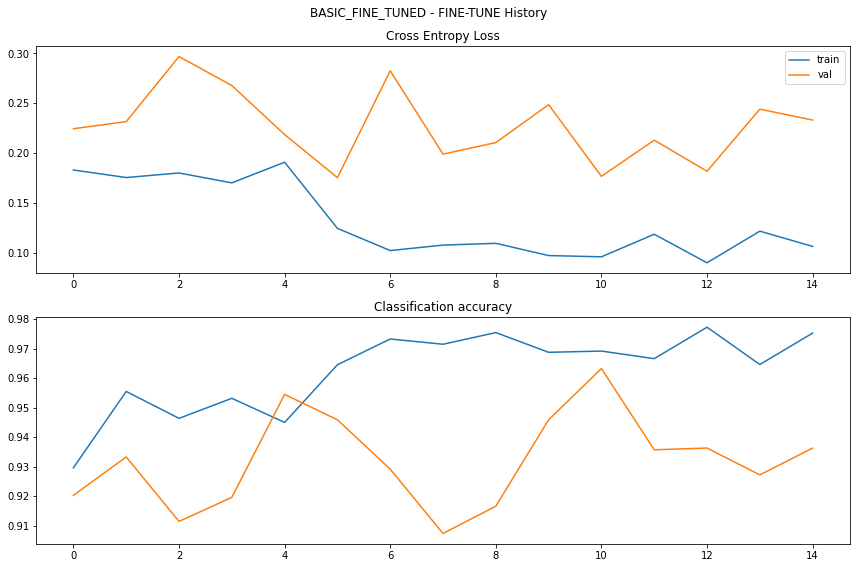

In [23]:
fig = plot_training_history(train_history=ft_train_history, val_history=ft_val_history, model_name=MODEL_NAME, phase_name="FINE-TUNE", out_dir=OUT_DIR)
fig.show()

Clean GPU memory again

In [63]:
model = None

gc.collect()
torch.cuda.empty_cache()
torch.cuda.mem_get_info(device)

(2122488219, 4294836224)

# Fine-tune the fine-tuning with a higher learning rate to escape local minima

In [64]:
best_checkpoint = torch.load(f"{OUT_DIR}/{MODEL_NAME}_ft_best_model.pth")
model = get_model(n_classes=N_CLASSES)
model.load_state_dict(best_checkpoint["model"])
best_checkpoint = None

model.to(device)


print("Loaded best model...")

Loaded best model...


In [65]:
ft_ft_optimizer = optim.Adam(
    params=model.parameters(),
    lr=5e-5,
    betas=(0.9, 0.999),
    weight_decay=5e-4,
    amsgrad=True
)

ft_ft_lr_scheduler = optim.lr_scheduler.ExponentialLR(
    optimizer=ft_ft_optimizer,
    gamma=0.8 # Faster decay as we just want to escape local minima
)

In [66]:
FT_FT_NUM_EPOCHS = 10
model.features.requires_grad_(True) # Unfreeze feature layer for fine-tuning

ft_ft_train_history = {
    "loss": [],
    "accuracy": [],
}

ft_ft_val_history = {
    "loss": [],
    "accuracy": [],
}

ft_ft_best_val_loss = ft_best_val_loss
ft_ft_best_val_accuracy = ft_best_val_accuracy
ft_ft_best_epoch = -1

print(f"Starting {MODEL_NAME} fine-tuning...")

for epoch in range(1, FT_FT_NUM_EPOCHS + 1):
    print(f"Epoch[{epoch}/{FT_FT_NUM_EPOCHS}]")
    (train_target, train_preds, train_probs, _), train_loss = epoch_iter(
        dataloader=train_dataloader,
        model=model,
        loss_fn=loss_fn,
        device=device,
        is_train=True,
        optimizer=ft_ft_optimizer,
        lr_scheduler=ft_ft_lr_scheduler
    )

    train_accuracy = metric_scorer(torch.tensor(np.array(train_probs)), torch.tensor(np.array(train_target))).item()
    print(f"Training loss: {train_loss:.3f}\t Training micro accuracy: {train_accuracy:.3f}")

    (val_target, val_preds, val_probs, _), val_loss = epoch_iter(
        dataloader=val_dataloader,
        model=model,
        loss_fn=loss_fn,
        device=device,
        is_train=False,
    )

    val_accuracy = metric_scorer(torch.tensor(np.array(val_probs)), torch.tensor(np.array(val_target))).item()
    print(f"Validation loss: {val_loss:.3f}\t Validation micro accuracy: {val_accuracy:.3f}")

    # Save best model
    if val_loss < ft_ft_best_val_loss:
        ft_ft_best_val_loss = val_loss
        ft_ft_best_val_accuracy = val_accuracy
        ft_ft_best_epoch = epoch
        save_dict = {"model": model.state_dict(), "optimizer": ft_ft_optimizer.state_dict(), "lr_scheduler": ft_ft_lr_scheduler.state_dict(), "epoch": epoch}
        torch.save(save_dict, f"{OUT_DIR}/{MODEL_NAME}_ft_ft_best_model.pth")

    # Save latest model
    save_dict = {"model": model.state_dict(), "optimizer": ft_ft_optimizer.state_dict(), "lr_scheduler": ft_ft_lr_scheduler.state_dict(), "epoch": epoch}
    torch.save(save_dict, f"{OUT_DIR}/{MODEL_NAME}_ft_ft_latest_model.pth")

    # Save loss and accuracy in history
    ft_ft_train_history["loss"].append(train_loss)
    ft_ft_train_history["accuracy"].append(train_accuracy)

    ft_ft_val_history["loss"].append(val_loss)
    ft_ft_val_history["accuracy"].append(val_accuracy)

    print("----------------------------------------------------------------")

print(
    f"\nFinished fine-fine-tuning..."
    f"\nBest epoch: {ft_ft_best_epoch}\t Validation loss on best epoch: {ft_ft_best_val_loss}\t Accuracy on best epoch: {ft_ft_best_val_accuracy}"
)

Starting BASIC_FINE_TUNED fine-tuning...
Epoch[1/10]


100%|██████████| 61/61 [00:27<00:00,  2.24it/s]


Training loss: 0.130	 Training micro accuracy: 0.956


100%|██████████| 15/15 [00:05<00:00,  2.87it/s]


Validation loss: 0.374	 Validation micro accuracy: 0.908
----------------------------------------------------------------
Epoch[2/10]


100%|██████████| 61/61 [00:30<00:00,  2.00it/s]


Training loss: 0.152	 Training micro accuracy: 0.960


100%|██████████| 15/15 [00:05<00:00,  2.99it/s]


Validation loss: 0.358	 Validation micro accuracy: 0.901
----------------------------------------------------------------
Epoch[3/10]


100%|██████████| 61/61 [00:29<00:00,  2.10it/s]


Training loss: 0.140	 Training micro accuracy: 0.967


100%|██████████| 15/15 [00:09<00:00,  1.57it/s]


Validation loss: 0.325	 Validation micro accuracy: 0.921
----------------------------------------------------------------
Epoch[4/10]


100%|██████████| 61/61 [00:33<00:00,  1.83it/s]


Training loss: 0.076	 Training micro accuracy: 0.973


100%|██████████| 15/15 [00:05<00:00,  2.69it/s]


Validation loss: 0.261	 Validation micro accuracy: 0.953
----------------------------------------------------------------
Epoch[5/10]


100%|██████████| 61/61 [00:36<00:00,  1.66it/s]


Training loss: 0.069	 Training micro accuracy: 0.982


100%|██████████| 15/15 [00:04<00:00,  3.06it/s]


Validation loss: 0.205	 Validation micro accuracy: 0.955
----------------------------------------------------------------
Epoch[6/10]


100%|██████████| 61/61 [00:32<00:00,  1.88it/s]


Training loss: 0.095	 Training micro accuracy: 0.975


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


Validation loss: 0.242	 Validation micro accuracy: 0.945
----------------------------------------------------------------
Epoch[7/10]


100%|██████████| 61/61 [00:30<00:00,  2.02it/s]


Training loss: 0.073	 Training micro accuracy: 0.971


100%|██████████| 15/15 [00:07<00:00,  2.09it/s]


Validation loss: 0.159	 Validation micro accuracy: 0.964
----------------------------------------------------------------
Epoch[8/10]


100%|██████████| 61/61 [00:34<00:00,  1.77it/s]


Training loss: 0.075	 Training micro accuracy: 0.975


100%|██████████| 15/15 [00:06<00:00,  2.41it/s]


Validation loss: 0.233	 Validation micro accuracy: 0.946
----------------------------------------------------------------
Epoch[9/10]


100%|██████████| 61/61 [00:35<00:00,  1.71it/s]


Training loss: 0.069	 Training micro accuracy: 0.984


100%|██████████| 15/15 [00:15<00:00,  1.02s/it]


Validation loss: 0.130	 Validation micro accuracy: 0.981
----------------------------------------------------------------
Epoch[10/10]


100%|██████████| 61/61 [00:37<00:00,  1.62it/s]


Training loss: 0.053	 Training micro accuracy: 0.978


100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Validation loss: 0.232	 Validation micro accuracy: 0.955
----------------------------------------------------------------

Finished fine-fine-tuning...
Best epoch: 9	 Validation loss on best epoch: 0.13000060762278737	 Accuracy on best epoch: 0.9814814925193787


C:\Users\telmo\AppData\Local\Temp/ipykernel_16048/2914740446.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


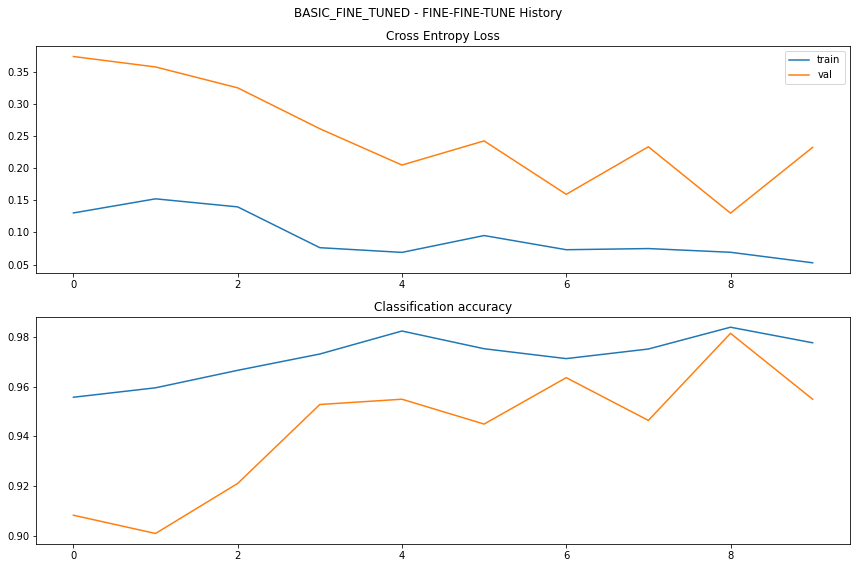

In [67]:
fig = plot_training_history(train_history=ft_ft_train_history, val_history=ft_ft_val_history, model_name=MODEL_NAME, phase_name="FINE-FINE-TUNE", out_dir=OUT_DIR)
fig.show()

In [68]:
model = None

gc.collect()
torch.cuda.empty_cache()
torch.cuda.mem_get_info(device)

(2063767963, 4294836224)

# Test the model

In [69]:
best_checkpoint = torch.load(f"{OUT_DIR}/{MODEL_NAME}_ft_ft_best_model.pth")
model = get_model(n_classes=N_CLASSES)
model.load_state_dict(best_checkpoint["model"])
best_checkpoint = None

model.to(device)


print("Loaded best fine-tuned model...")

Loaded best fine-tuned model...


In [70]:
(test_target, test_preds, test_probs, test_ids), test_loss = epoch_iter(
    dataloader=test_dataloader,
    model=model,
    loss_fn=loss_fn,
    device=device,
    is_train=False,
)

100%|██████████| 264/264 [00:20<00:00, 12.81it/s]


In [71]:
test_metrics = torchmetrics.MetricCollection(
    metrics={
        "micro_accuracy": metric_scorer,
        "macro_accuracy": torchmetrics.Accuracy(
            threshold=0.5,
            num_classes=N_CLASSES,
            average="macro",
        ),
        "weighted_accuracy": torchmetrics.Accuracy(
            threshold=0.5,
            num_classes=N_CLASSES,
            average="weighted",
        ),
        "micro_f1_score": torchmetrics.F1Score(
            threshold=0.5,
            num_classes=N_CLASSES,
            average="micro",
        ),
        "macro_f1_score": torchmetrics.F1Score(
            threshold=0.5,
            num_classes=N_CLASSES,
            average="macro",
        ),
        "weighted_f1_score": torchmetrics.F1Score(
            threshold=0.5,
            num_classes=N_CLASSES,
            average="weighted",
        )
    }
)

test_probs_tensor = torch.tensor(np.array(test_probs))
test_target_tensor = torch.tensor(np.array(test_target))

test_metrics_scores = test_metrics(test_probs_tensor, test_target_tensor)

print(test_metrics_scores)

{'macro_accuracy': tensor(0.8835), 'macro_f1_score': tensor(0.8962), 'micro_accuracy': tensor(0.9470), 'micro_f1_score': tensor(0.9470), 'weighted_accuracy': tensor(0.9470), 'weighted_f1_score': tensor(0.9451)}


In [72]:
from sklearn.metrics import classification_report
print(classification_report(y_true=test_target, y_pred=test_preds, target_names=list(label_encode_map.keys())[1:]))

              precision    recall  f1-score   support

trafficlight       0.89      1.00      0.94        24
  speedlimit       0.96      0.98      0.97       192
   crosswalk       0.81      0.68      0.74        25
        stop       1.00      0.87      0.93        23

    accuracy                           0.95       264
   macro avg       0.92      0.88      0.90       264
weighted avg       0.95      0.95      0.95       264



In [73]:
from PIL import Image
def showErrors(imageIds, y_true, y_pred, limit=None, img_dir = "./"):
    N = limit if limit is not None else len(imageIds)
    N_COLS = 4
    N_ROWS = N // 4 + N % 4
    shown = 0
    fig = plt.figure(figsize=(8*N_COLS, 12*N_ROWS))
    for (imageId, correct, predicted) in zip(imageIds, y_true, y_pred):
        if correct == predicted:
            continue
        image = np.array(Image.open(f"{img_dir}/{imageId}.png").convert("RGB"))
        target_label = f"TRUE: {label_decode_map[correct]}"
        predicted_label = f"PRED: {label_decode_map[predicted]}"

        ax = fig.add_subplot(N_ROWS, N_COLS, shown + 1)
        ax.axis("off")
        ax.text(0, -8, imageId, fontsize=14, color="black")
        ax.text((len(imageId) + 1) * 8, -8, target_label, fontsize=14, color='green') # correct
        ax.text((len(imageId) + len(target_label) + 1) * 8, -8, predicted_label, fontsize=14, color='red')  # predicted
        ax.imshow(image)
        
        shown += 1

        if shown >= N:
            break

    plt.tight_layout()
    plt.show()

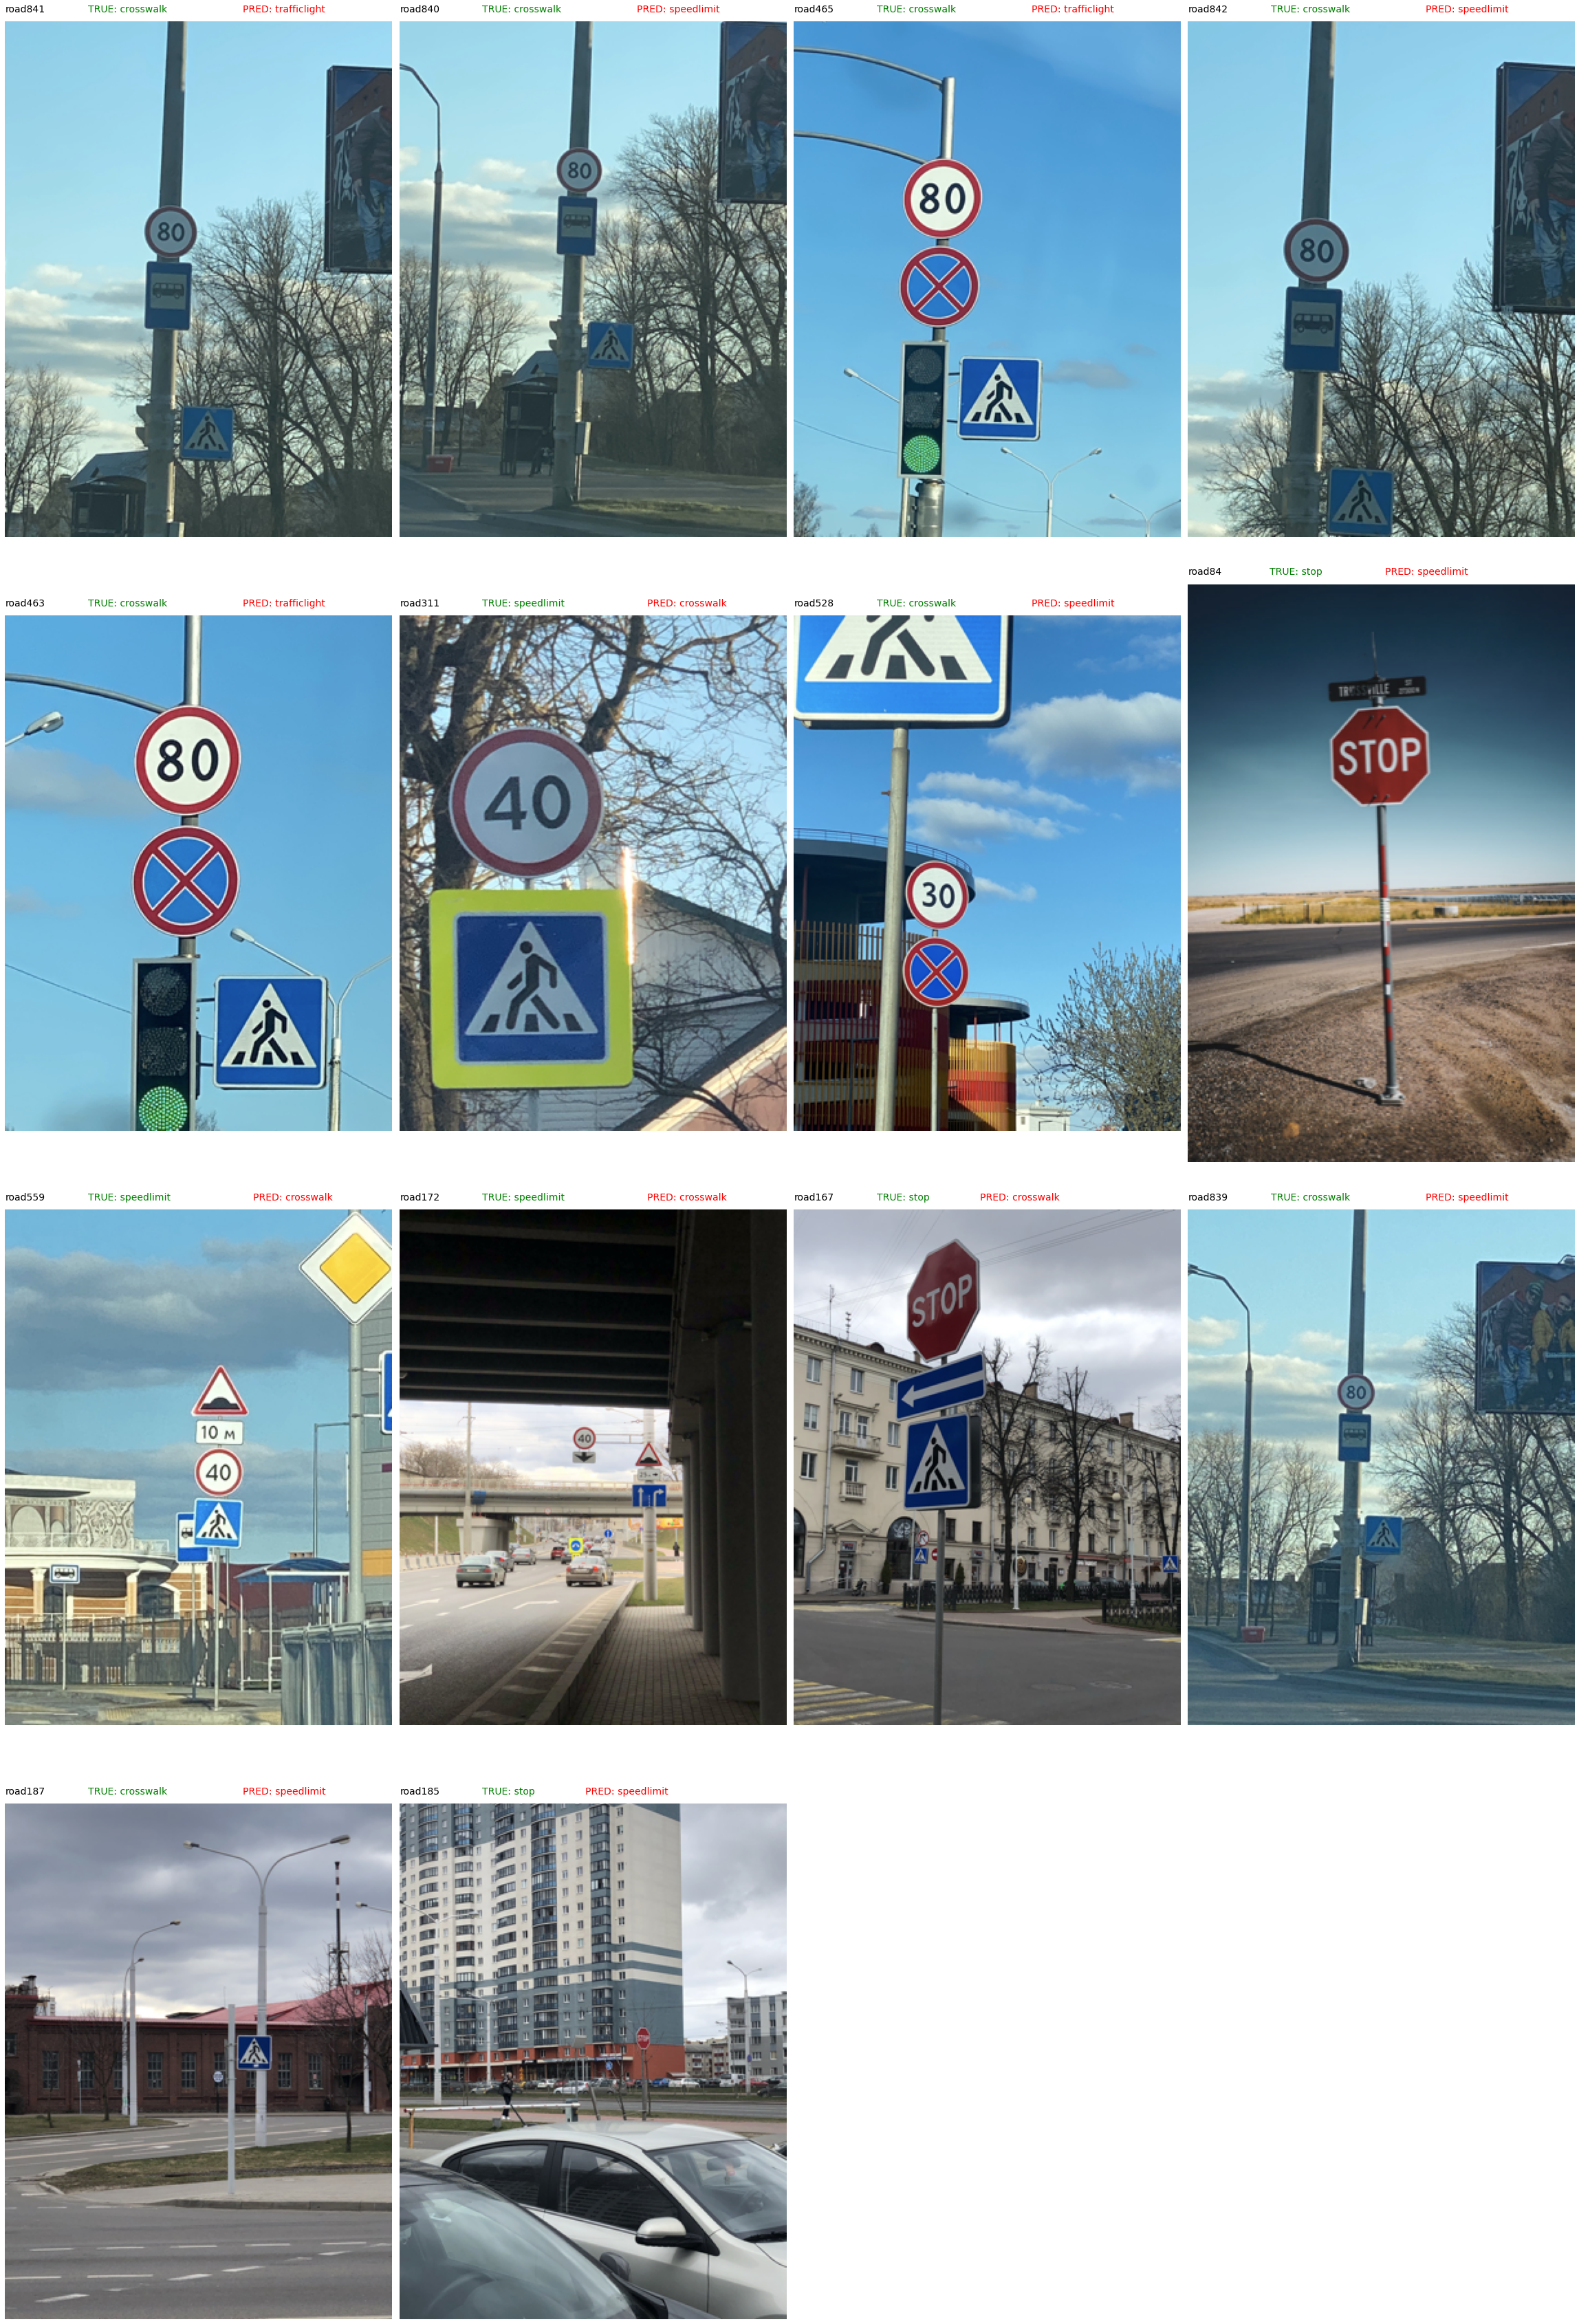

In [74]:
showErrors(test_ids, test_target, test_preds, limit=None, img_dir=IMG_DIR)